In [132]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
import shap
import seaborn as sns

def calculate_correlations(shap_values, features_df, feature_names, num_classes):
    correlation_df = pd.DataFrame()

    for feature in feature_names:
        correlation_dict = {'feature': feature}

        for i in range(num_classes):
            shap_values_i = shap_values[i][:, features_df.columns.get_loc(feature)]
            feature_values_i = features_df[feature].values

            correlation_coefficient_i = np.corrcoef(shap_values_i, feature_values_i)[0, 1]
            correlation_dict[f'correlation_{i}'] = correlation_coefficient_i

        correlation_df = correlation_df.append(correlation_dict, ignore_index=True)

    return correlation_df

def XGBoost(X, y):
    # データを訓練用とテスト用に分割
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # 訓練データをさらに訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

    # モデルのパラメータを設定(CPU)
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class' : 5,
        'eta': 0.1,
        'max_depth': 4,
        'seed': 0,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor'
    }
    
    # データをpandas.DataFrame形式で保存
    #X_train_df = pd.DataFrame(X_train, columns=column_names)
    #y_train_df = pd.DataFrame(y_train, columns=column_names)

    # 訓練データと検証データをXGBoostのDMatrix形式に変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 訓練データと検証データのセットをリストに格納
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # モデルを訓練
    bst = xgb.train(params, dtrain, num_boost_round=10000, evals=evals, early_stopping_rounds=100)

    # テストデータをDMatrix形式に変換
    dtest = xgb.DMatrix(X_test)

    # 訓練データで予測
    y_train_pred = bst.predict(dtrain)

    # テストデータで予測
    y_pred = bst.predict(dtest)

    # 評価
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_accuracy*100:.2f}%")

    # 評価
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
        
    return X_train, y_train, bst, y_pred

def normalize_per_state(df, start, end):
    scaler = StandardScaler()
    df.iloc[start:end, :] = scaler.fit_transform(df.iloc[start:end, :])
    return df

In [133]:
# 1秒ごとのデータに分割
#n_samples_per_second = 128  # 128Hzのサンプリングレート
#total_seconds = 10  # 全体の秒数

# データの読み込み
df = pd.read_csv('ALL.csv') # 99.48%
#df = pd.read_csv('ALL_RightLeft.csv') # 99.58%
#df = pd.read_csv('ALL_UpperUnder.csv') # 99.69%

"""""
# チャンネルごとに正規化
scaler = StandardScaler()
for column in df.columns[:-1]:  # 'State'列を除くすべての列
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
"""""

'""\n# チャンネルごとに正規化\nscaler = StandardScaler()\nfor column in df.columns[:-1]:  # \'State\'列を除くすべての列\n    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))\n'

In [135]:
# Hzごと
# 特徴量と目的変数を抽出する
#X = df.drop('Label', axis=1)  # 'Label'以外の列
#X = df.drop([ 'P1',  'Oz', 'P2','Label','Fp1','Fp2','F3','F4','Fz','O1','O2','P3','Pz','P4'], axis=1)  # '10/20法
X = df[['T7','T8','C5','C6']]
y = df['Label']  # 'Label'を目標変数

#XGBoost
X_train_df, y_train_df, bst, ypred = XGBoost(X, y)

[0]	train-mlogloss:1.46057	eval-mlogloss:1.46113
[1]	train-mlogloss:1.34008	eval-mlogloss:1.34125
[2]	train-mlogloss:1.23819	eval-mlogloss:1.23982
[3]	train-mlogloss:1.14967	eval-mlogloss:1.15218
[4]	train-mlogloss:1.07342	eval-mlogloss:1.07632
[5]	train-mlogloss:1.00664	eval-mlogloss:1.01077
[6]	train-mlogloss:0.94412	eval-mlogloss:0.94948
[7]	train-mlogloss:0.88872	eval-mlogloss:0.89525
[8]	train-mlogloss:0.84183	eval-mlogloss:0.84885
[9]	train-mlogloss:0.79796	eval-mlogloss:0.80538
[10]	train-mlogloss:0.76040	eval-mlogloss:0.76886
[11]	train-mlogloss:0.72453	eval-mlogloss:0.73349
[12]	train-mlogloss:0.69109	eval-mlogloss:0.70122
[13]	train-mlogloss:0.66275	eval-mlogloss:0.67351
[14]	train-mlogloss:0.63674	eval-mlogloss:0.64851
[15]	train-mlogloss:0.61207	eval-mlogloss:0.62477
[16]	train-mlogloss:0.58899	eval-mlogloss:0.60259
[17]	train-mlogloss:0.56902	eval-mlogloss:0.58346
[18]	train-mlogloss:0.54669	eval-mlogloss:0.56254
[19]	train-mlogloss:0.53022	eval-mlogloss:0.54687
[20]	train

[163]	train-mlogloss:0.12707	eval-mlogloss:0.21449
[164]	train-mlogloss:0.12660	eval-mlogloss:0.21443
[165]	train-mlogloss:0.12610	eval-mlogloss:0.21448
[166]	train-mlogloss:0.12560	eval-mlogloss:0.21423
[167]	train-mlogloss:0.12508	eval-mlogloss:0.21396
[168]	train-mlogloss:0.12467	eval-mlogloss:0.21382
[169]	train-mlogloss:0.12405	eval-mlogloss:0.21366
[170]	train-mlogloss:0.12352	eval-mlogloss:0.21340
[171]	train-mlogloss:0.12299	eval-mlogloss:0.21337
[172]	train-mlogloss:0.12253	eval-mlogloss:0.21305
[173]	train-mlogloss:0.12211	eval-mlogloss:0.21292
[174]	train-mlogloss:0.12181	eval-mlogloss:0.21278
[175]	train-mlogloss:0.12141	eval-mlogloss:0.21265
[176]	train-mlogloss:0.12119	eval-mlogloss:0.21261
[177]	train-mlogloss:0.12087	eval-mlogloss:0.21256
[178]	train-mlogloss:0.12053	eval-mlogloss:0.21239
[179]	train-mlogloss:0.12028	eval-mlogloss:0.21237
[180]	train-mlogloss:0.11987	eval-mlogloss:0.21238
[181]	train-mlogloss:0.11961	eval-mlogloss:0.21222
[182]	train-mlogloss:0.11924	ev

[324]	train-mlogloss:0.07164	eval-mlogloss:0.20817
[325]	train-mlogloss:0.07144	eval-mlogloss:0.20833
[326]	train-mlogloss:0.07128	eval-mlogloss:0.20849
[327]	train-mlogloss:0.07116	eval-mlogloss:0.20860
[328]	train-mlogloss:0.07093	eval-mlogloss:0.20880
[329]	train-mlogloss:0.07078	eval-mlogloss:0.20880
[330]	train-mlogloss:0.07061	eval-mlogloss:0.20883
[331]	train-mlogloss:0.07049	eval-mlogloss:0.20885
[332]	train-mlogloss:0.07023	eval-mlogloss:0.20893
[333]	train-mlogloss:0.07010	eval-mlogloss:0.20895
[334]	train-mlogloss:0.06988	eval-mlogloss:0.20914
[335]	train-mlogloss:0.06963	eval-mlogloss:0.20909
[336]	train-mlogloss:0.06925	eval-mlogloss:0.20896
[337]	train-mlogloss:0.06884	eval-mlogloss:0.20908
[338]	train-mlogloss:0.06864	eval-mlogloss:0.20919
[339]	train-mlogloss:0.06848	eval-mlogloss:0.20918
[340]	train-mlogloss:0.06821	eval-mlogloss:0.20905
[341]	train-mlogloss:0.06788	eval-mlogloss:0.20885
[342]	train-mlogloss:0.06758	eval-mlogloss:0.20872
[343]	train-mlogloss:0.06735	ev

In [136]:
X_train_df

,T7,T8,C5,C6
8102,-111.400,-55.204,-9.535,32.451
2404,607.635,97.971,248.047,-9.015
1682,-143.130,37.233,91.390,42.075
3401,302.747,94.097,197.325,38.371
9544,11.236,-17.536,59.063,7.265
...,...,...,...,...
4249,-26.513,-56.809,-47.473,-7.870
7499,199.066,-48.506,6.657,-21.622
4923,67.632,-85.261,-19.267,18.976
7568,252.938,-40.792,49.744,17.379


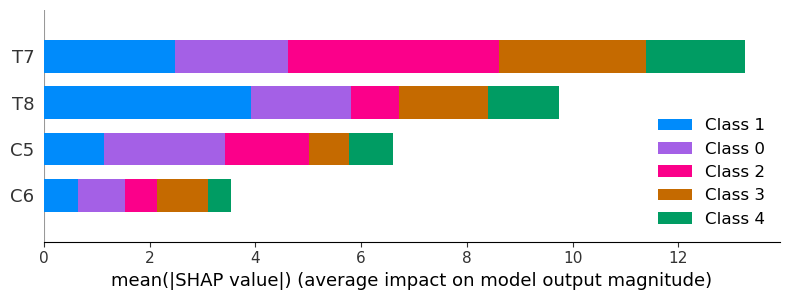

In [137]:
#各特徴重要度を表示する
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train_df,y_train_df)

shap.summary_plot(shap_values, X_train_df)
#0 普通
#1 右手
#2 左手
#3 右足
#4 左足

In [6]:
X

,Cz,Fz,Fp1,F3,C3,O1,O2,P4,C4,F4,Fp2,Label
0,-0.050,-26.657,-184.020,-68.154,-23.770,-0.507,14.237,-21.743,-12.972,-30.464,-37.312,0
1,-15.932,-38.414,-207.915,-79.357,-37.578,-22.023,1.927,-35.554,-33.451,-47.852,-35.226,0
2,-4.133,-30.179,-193.362,-55.199,-21.659,-23.026,0.901,-35.518,-31.881,-36.533,-39.289,0
3,4.068,-10.168,-164.992,-30.041,-3.194,-1.998,16.269,-24.724,-13.406,-14.468,-30.540,0
4,-12.842,-11.183,-161.753,-40.257,-9.851,1.078,16.765,-23.675,-12.880,-24.699,-19.751,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9596,-6.308,12.945,-59.567,43.059,26.394,-15.840,4.786,7.091,1.499,2.560,-118.727,4
9597,2.407,15.493,-38.502,37.893,24.318,-8.652,15.540,9.646,6.108,8.193,-106.825,4
9598,2.405,15.478,-46.148,26.072,11.486,-9.668,5.790,4.513,0.467,12.283,-118.501,4
9599,12.649,25.709,-45.590,44.489,24.795,-0.949,10.908,9.632,9.175,24.054,-112.235,4


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


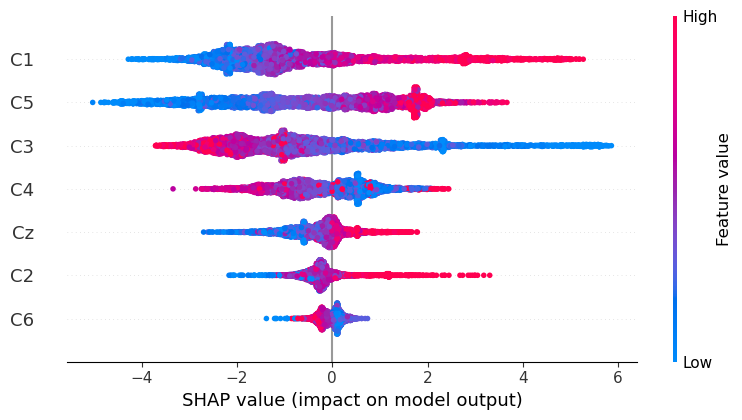

In [76]:
# SHAP値をプロット
shap.summary_plot(shap_values[0], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[0], X_train_df)
# 普通

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


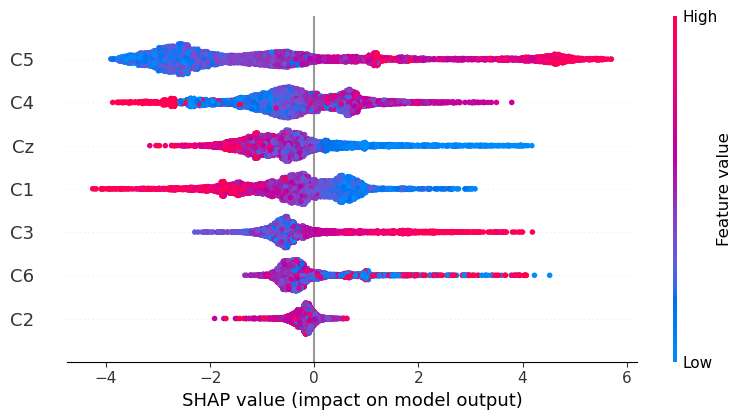

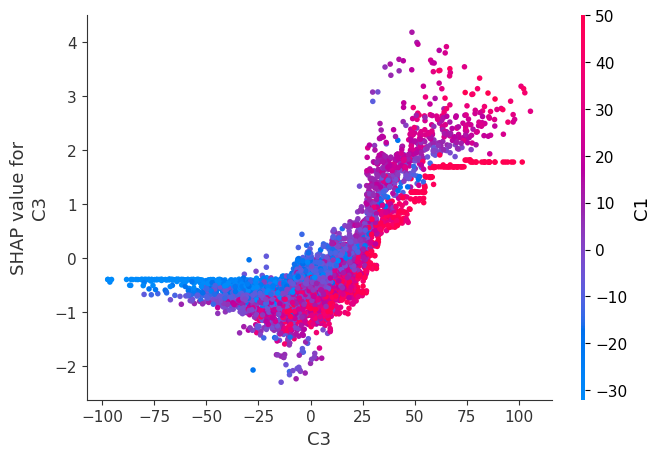

In [82]:
# SHAP値をプロット
shap.summary_plot(shap_values[1], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
shap.dependence_plot("C3", shap_values[1], X_train_df)
# 右手

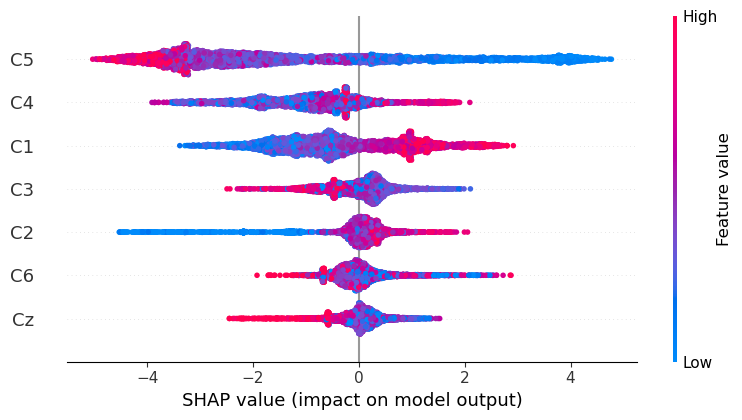

In [78]:
# SHAP値をプロット
shap.summary_plot(shap_values[2], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左手

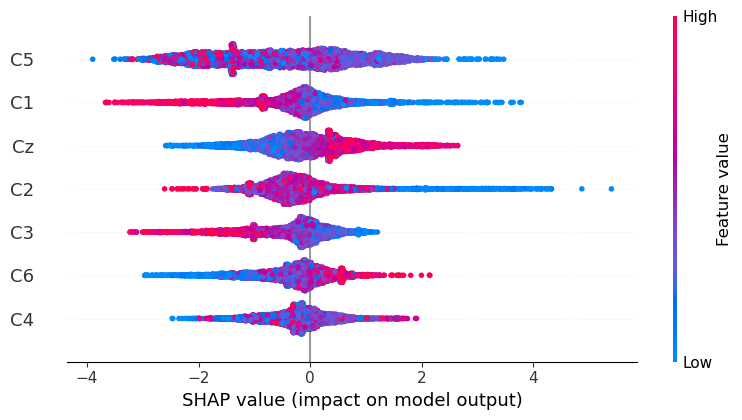

In [79]:
# SHAP値をプロット
shap.summary_plot(shap_values[3], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 右足

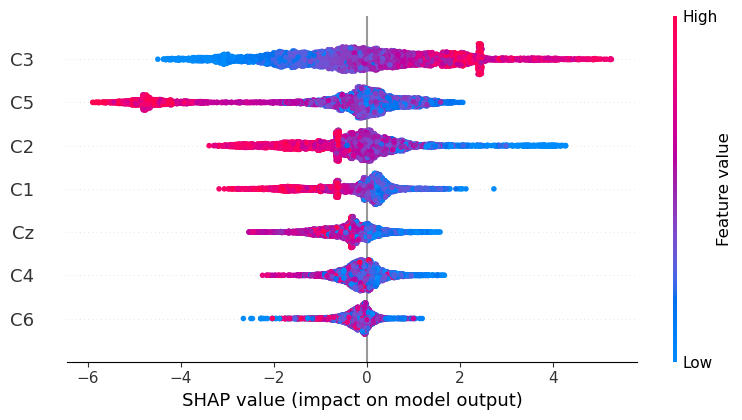

In [80]:
# SHAP値をプロット
shap.summary_plot(shap_values[4], X_train_df, max_display=X_train_df.shape[1])
#各ｃｈの電圧値とSHAP値の線形グラフ
#shap.dependence_plot("O2", shap_values[1], X_train_df)
# 左足

In [10]:
num_classes = 5  # クラス数を設定
correlation_df = calculate_correlations(shap_values, X_train_df, column_names, num_classes).T
correlation_df

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
feature,Cz,Fz,Fp1,F3,C1,C3,T7,C5,CP5,CP3,...,P2,CP2,CP4,CP6,C6,T8,C4,C2,F4,Fp2
correlation_0,0.810988,-0.766331,-0.625519,-0.612685,0.862686,-0.758824,-0.297234,0.788873,-0.632299,-0.809433,...,-0.697578,0.106143,-0.241362,0.795139,-0.700924,-0.872544,-0.59979,0.532927,-0.640828,0.868505
correlation_1,-0.769314,-0.463344,-0.804074,-0.532088,-0.455273,0.85354,0.924133,0.722813,0.560965,NaN,...,0.78542,-0.374326,0.81424,-0.831902,-0.669027,0.892211,0.141122,0.121532,-0.718754,-0.008991
correlation_2,-0.781393,0.693305,-0.731118,-0.685555,0.794201,-0.720798,-0.708802,-0.695566,0.822583,0.569177,...,-0.564023,-0.317611,-0.639801,-0.804692,-0.448782,-0.78174,-0.581498,0.256973,0.641458,0.792439
correlation_3,0.800697,-0.488101,0.85363,0.631584,-0.664009,0.326075,0.799863,-0.731817,0.580333,-0.697619,...,-0.776853,0.667152,0.659022,0.823234,0.765331,-0.877457,0.468709,-0.287248,-0.046952,-0.489249
correlation_4,0.443738,0.814355,0.730295,0.799195,-0.879276,0.75615,-0.892087,-0.87551,-0.802491,-0.706897,...,0.818273,-0.058002,-0.851632,0.761499,0.766336,0.798987,-0.480074,-0.849,-0.704647,-0.78582
